In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import logging
from tqdm import tqdm
import os
from easydict import EasyDict as edict

from simple_deep_learning.mnist_extended.semantic_segmentation import (create_semantic_segmentation_dataset, display_segmented_image,
                                                                       display_grayscale_array, plot_class_masks)

2024-04-26 12:37:19.518646: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-26 12:37:19.550307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 12:37:20.031813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
np.random.seed(seed=9)
cur_dir ='/home/yiwen/TUM/BMW_TEST/simple_deep_learning'
save_checkpoint_path = os.path.join(cur_dir, "checkpoint/")
log_path = os.path.join(cur_dir, "logs")

if not os.path.exists(log_path):
    os.makedirs(log_path)
if not os.path.exists(save_checkpoint_path):
    os.makedirs(save_checkpoint_path)


config = edict(d={
    "num_train_samples": 20000,
    "num_test_samples": 2500,
    "image_shape": (60, 60),
    "num_classes": 3,
    "max_num_digits_per_image": 4,
    "batch_size": 32,
    "learning_rate": 0.001,
    "num_epochs": 16,
    "outf":save_checkpoint_path,
    "log_dir":log_path,
})
writer = SummaryWriter(log_dir=os.path.join(cur_dir, 'runs'))
logging.basicConfig(filename=os.path.join(config.log_dir, 'train.log'), level=logging.DEBUG,
    filemode = 'w', format='%(levelname)s:%(asctime)s:%(message)s', datefmt='%Y-%d-%m %H:%M:%S')


In [3]:
np.random.seed(1)
train_x, train_y, test_x, test_y = create_semantic_segmentation_dataset(config.num_train_samples, config.num_test_samples, config.image_shape, config.num_classes, config.max_num_digits_per_image,
                                                                        num_classes=config.num_classes)

In [4]:
class SemanticSegmentationDataset(Dataset):
    def __init__(self, input, label):                
        self.input = input
        self.label = label
        
        # self._generate_data()
        
    # def _generate_data(self):
    #     np.random.seed(1)
    #     self.train_x, self.train_y, self.test_x, self.test_y = create_semantic_segmentation_dataset(num_train_samples=self.num_train_samples,
    #                                                                     num_test_samples=self.num_test_samples,
    #                                                                     image_shape=self.image_shape,
    #                                                                     num_classes=self.num_classes,
    #                                                                     max_num_digits_per_image=self.max_num_digits_per_image,
    #                                                                     labels_are_exclusive=True)
    #     # print(self.train_x.shape, self.train_y.shape)
    def __len__(self):
        return len(self.input)


    def __getitem__(self, idx):
        image = torch.from_numpy(self.input[idx]).float().permute(2,0,1)
        mask = torch.from_numpy(self.label[idx]).float().permute(2,0,1)
        return image, mask

# Assuming 'train_x' and 'train_y' are loaded similarly as numpy arrays
train_dataset = SemanticSegmentationDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# a = next(iter(train_loader))
# print(len(train_loader))

test_dataset = SemanticSegmentationDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        
        # if not mid_channels:
        #     mid_channels = out_channels
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)
    
class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super(UpSampling, self).__init__()
        if bilinear:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1)
            )

        else:
            self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # print('x1', x1.shape)
        x = torch.cat([x2, x1], dim=1)
        return x
            
class UNet(nn.Module):
    def __init__(self, num_classes=5, n_channels=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.num_classes = num_classes
        
        # Down part of UNet
        self.down1 = ConvBlock(n_channels, 16)
        self.down2 = ConvBlock(16, 32)
        self.down3 = ConvBlock(32, 64)
        
        # Up part of UNet
        self.up1 = UpSampling(64, 32)
        self.up_conv1 = ConvBlock(32*2, 32)
        self.up2 = UpSampling(32, 16)
        self.up_conv2 = ConvBlock(16*2, 16)
        
        self.final_conv = nn.Conv2d(16, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = nn.MaxPool2d(kernel_size=2)(x1)
        x2 = self.down2(x2)
        x3 = nn.MaxPool2d(kernel_size=2)(x2)
        x3 = self.down3(x3)
        
        # Decoder
        x = self.up1(x3, x2)
        x = self.up_conv1(x)
        x = self.up2(x, x1)
        x = self.up_conv2(x)
        out = self.final_conv(x)
        
        return out

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
def mIoU(pred, target, num_classes):
    """Calculate mean Intersection over Union (mIoU) for given predictions and target masks,
    ignoring classes not present in the target."""
    ious = []
    for bs in range(target.shape[0]):
        for cls in range(num_classes):
            pred_inds = pred[bs, cls] > 0.5  # Predicted presence of class
            target_inds = target[bs, cls] > 0.5  # Actual presence of class

            # Check if there are any actual pixels for this class
            if target_inds.any():
                intersection = (pred_inds & target_inds).sum(dim=[0, 1])  # True Positives
                union = (pred_inds | target_inds).sum(dim=[0, 1])  # Union of predicted and actual areas

                # Only calculate IoU if union is not zero
                if union.sum().item() > 0:
                    iou = intersection.float() / union.float()
                    ious.append(iou)  # Append IoU for this class to list
                    # print(iou)
                else:
                    # Optionally handle zero union here, e.g., by appending a specific value like 0 or skipping it
                    pass
            else:
                pass

    # Flatten list of tensors and calculate mean
    if ious:
        # all_ious = torch.cat(ious)
        return torch.nanmean(torch.tensor(ious)).item()  # Average IoU across all non-empty classes
    else:
        return float('nan')  # Return NaN if no classes have pixels in target
    
def calculate_binary_entropy(logits):
    """Calculate the entropy for binary predictions using sigmoid."""
    p = torch.sigmoid(logits)  # Convert logits to probabilities for binary classification
    log_p = torch.log(p + 1e-9)  # Log of probability, adding a small constant to avoid log(0)
    log_one_minus_p = torch.log(1 - p + 1e-9)  # Log of 1 minus the probability
    
    # Binary entropy formula: -p*log(p) - (1-p)*log(1-p)
    entropy = - (p * log_p + (1 - p) * log_one_minus_p)
    return entropy.mean().item()  # Mean over all dimensions

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(num_classes=config.num_classes).to(device)
print('Model_parameters:', count_parameters(model))
criterion = nn.BCEWithLogitsLoss()
m = nn.Sigmoid()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_eval_loss = np.inf

for epoch in range(config.num_epochs):
    train_losses = []
    val_losses = []
    train_entropy = []
    train_miou = []
    val_entropy = []
    val_miou = []
    model.train()
    tqdm_bar = tqdm(train_loader, position=0, leave=True)
    for i, data in enumerate(tqdm_bar):
        image, mask = data
        image, mask = image.to(device), mask.to(device)
        # print(image.shape)
        # print(mask.shape)
        optimizer.zero_grad()
        output = model(image)
        # print('11', output.shape)
        loss = criterion(output, mask)
        
        entropy = calculate_binary_entropy(output)  # Calculate entropy for uncertainty
        miou = mIoU(output, mask, num_classes=config.num_classes)  # Calculate mIoU
        
        train_losses.append(loss.item())
        train_entropy.append(entropy)
        train_miou.append(miou)
        loss.backward()
        optimizer.step()
        tqdm_bar.set_description(f"Epoch {epoch} Training Loss: {loss.item():.4f}")
    
    ave_train_loss = np.mean(train_losses)
    ave_train_entropy = np.mean(train_entropy)
    ave_train_miou = np.mean(train_miou)
    writer.add_scalar('Loss/Train', ave_train_loss, epoch)
    writer.add_scalar('Entropy/Train', ave_train_entropy, epoch)
    writer.add_scalar('mIoU/Train', ave_train_miou, epoch)
    logging.info(f'EPOCH {epoch} - train_loss: {ave_train_loss}, entropy: {ave_train_entropy}, mIoU: {ave_train_miou}')
    print(f'EPOCH {epoch} - train_loss: {ave_train_loss}, entropy: {ave_train_entropy}, mIoU: {ave_train_miou}')
    
    model.eval()
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            output = model(image)
            val_loss = criterion(output, mask)
            
            entropy = calculate_binary_entropy(output)  # Calculate entropy for uncertainty
            miou = mIoU(output, mask, num_classes=config.num_classes)  # Calculate mIoU
            
            val_losses.append(val_loss.detach().item())
            val_entropy.append(entropy)
            val_miou.append(miou)
            tqdm_bar.set_description(f"Epoch {epoch} Validation Loss: {val_loss.item():.4f}")
        ave_val_loss = sum(val_losses) / len(val_losses)
        ave_val_entropy = np.mean(val_entropy)
        ave_val_miou = np.mean(val_miou)
        writer.add_scalar('Loss/Validation', ave_val_loss, epoch)
        writer.add_scalar('Entropy/Validation', ave_val_entropy, epoch)
        writer.add_scalar('mIoU/Validation', ave_val_miou, epoch)
        logging.info(f'EPOCH {epoch} - val_loss: {ave_val_loss}, entropy: {ave_val_entropy}, mIoU: {ave_val_miou}')
        print(f'EPOCH {epoch} - val_loss: {ave_val_loss}, entropy: {ave_val_entropy}, mIoU: {ave_val_miou}')

        if ave_val_loss < best_eval_loss:
            print('Saving model')
            best_eval_loss = ave_val_loss
            torch.save(model.state_dict(), '%s/basis_model_best.pth' % (config.outf))

Model_parameters: 57043


Epoch 0 Training Loss: 0.0356: 100%|██████████| 625/625 [00:11<00:00, 54.74it/s]

EPOCH 0 - train_loss: 0.1614205256164074, entropy: 0.3015971686244011, mIoU: 0.4200111671447754


EPOCH 0 - val_loss: 0.035045468142326876, entropy: 0.08941866410306737, mIoU: 0.8114698136909099
Saving model


Epoch 1 Training Loss: 0.0207: 100%|██████████| 625/625 [00:10<00:00, 58.96it/s]

EPOCH 1 - train_loss: 0.027009442082047464, entropy: 0.05855901539325714, mIoU: 0.8386161145210266


EPOCH 1 - val_loss: 0.02307428263976604, entropy: 0.03888169185647482, mIoU: 0.843621880947789
Saving model


Epoch 2 Training Loss: 0.0168: 100%|██████████| 625/625 [00:11<00:00, 53.76it/s]

EPOCH 2 - train_loss: 0.020713406202197075, entropy: 0.03250571128427982, mIoU: 0.8645764254570008


EPOCH 2 - val_loss: 0.02110464269696157, entropy: 0.027030259512270553, mIoU: 0.8438148770151259
Saving model


Epoch 3 Training Loss: 0.0174: 100%|██████████| 625/625 [00:09<00:00, 64.95it/s]

EPOCH 3 - train_loss: 0.018833852502703665, entropy: 0.024940308701992035, mIoU: 0.8737259544372559


EPOCH 3 - val_loss: 0.01920899770022193, entropy: 0.02184931634441961, mIoU: 0.8599704647366004
Saving model


Epoch 4 Training Loss: 0.0175: 100%|██████████| 625/625 [00:09<00:00, 64.61it/s]

EPOCH 4 - train_loss: 0.017958649656176568, entropy: 0.021606991052627565, mIoU: 0.878456559085846


EPOCH 4 - val_loss: 0.018885160890655426, entropy: 0.020689358698982228, mIoU: 0.8827561064611508
Saving model


Epoch 5 Training Loss: 0.0178: 100%|██████████| 625/625 [00:09<00:00, 63.60it/s]

EPOCH 5 - train_loss: 0.01742748498916626, entropy: 0.01979685924053192, mIoU: 0.8816976934432983


EPOCH 5 - val_loss: 0.01849686032561939, entropy: 0.019025229341998885, mIoU: 0.8924599953844577
Saving model


Epoch 6 Training Loss: 0.0173: 100%|██████████| 625/625 [00:09<00:00, 65.21it/s]

EPOCH 6 - train_loss: 0.017080847212672234, entropy: 0.018702646937966347, mIoU: 0.8839376627922058


EPOCH 6 - val_loss: 0.017841773732459244, entropy: 0.017563660841293727, mIoU: 0.8736548672748518
Saving model


Epoch 7 Training Loss: 0.0159: 100%|██████████| 625/625 [00:09<00:00, 68.13it/s]

EPOCH 7 - train_loss: 0.016711259342730045, entropy: 0.017867738156020642, mIoU: 0.886426230430603


EPOCH 7 - val_loss: 0.018763862397003023, entropy: 0.017066160912472237, mIoU: 0.8666900833950767


Epoch 8 Training Loss: 0.0152: 100%|██████████| 625/625 [00:09<00:00, 64.32it/s]

EPOCH 8 - train_loss: 0.016514885933697224, entropy: 0.017357994669675827, mIoU: 0.8879120218276978


EPOCH 8 - val_loss: 0.018071525918814956, entropy: 0.016964783691624297, mIoU: 0.8803986205330377


Epoch 9 Training Loss: 0.0155: 100%|██████████| 625/625 [00:09<00:00, 69.02it/s]


EPOCH 9 - train_loss: 0.01633819132745266, entropy: 0.01697529389113188, mIoU: 0.8896270025253296
EPOCH 9 - val_loss: 0.017739296089150484, entropy: 0.017045092108789125, mIoU: 0.8681940617440622
Saving model


Epoch 10 Training Loss: 0.0158: 100%|██████████| 625/625 [00:09<00:00, 63.12it/s]


EPOCH 10 - train_loss: 0.016186958377063274, entropy: 0.016673201842606067, mIoU: 0.8906378417015076
EPOCH 10 - val_loss: 0.017885158463275132, entropy: 0.017174442852788335, mIoU: 0.8860766027547136


Epoch 11 Training Loss: 0.0157: 100%|██████████| 625/625 [00:12<00:00, 51.63it/s]

EPOCH 11 - train_loss: 0.016095673048496247, entropy: 0.016471588253974913, mIoU: 0.8903125289916992


EPOCH 11 - val_loss: 0.017647833433709566, entropy: 0.016601821490197996, mIoU: 0.8728049420103242
Saving model


Epoch 12 Training Loss: 0.0162: 100%|██████████| 625/625 [00:10<00:00, 59.14it/s]

EPOCH 12 - train_loss: 0.015896284671127796, entropy: 0.016210227683186532, mIoU: 0.8917678105354309


EPOCH 12 - val_loss: 0.017947584013395673, entropy: 0.01637841098576407, mIoU: 0.8674422781678695


Epoch 13 Training Loss: 0.0162: 100%|██████████| 625/625 [00:09<00:00, 64.44it/s]

EPOCH 13 - train_loss: 0.01583487550318241, entropy: 0.016080062180757523, mIoU: 0.8909880319595337


EPOCH 13 - val_loss: 0.017935396737973147, entropy: 0.016062431992326355, mIoU: 0.8703368909751312


Epoch 14 Training Loss: 0.0160: 100%|██████████| 625/625 [00:10<00:00, 59.35it/s]

EPOCH 14 - train_loss: 0.0157365212187171, entropy: 0.015945099768042564, mIoU: 0.8910924078941346


EPOCH 14 - val_loss: 0.017826136484553542, entropy: 0.01567389974016932, mIoU: 0.8816905338552934


Epoch 15 Training Loss: 0.0146: 100%|██████████| 625/625 [00:11<00:00, 54.61it/s]

EPOCH 15 - train_loss: 0.015644156078994276, entropy: 0.015814858549833298, mIoU: 0.8917726341247558


EPOCH 15 - val_loss: 0.017741583087304724, entropy: 0.01604987182241829, mIoU: 0.8583765950384019


Example 15


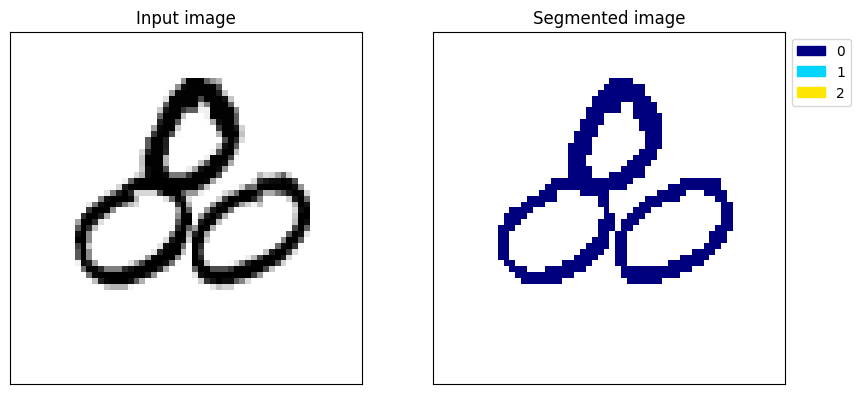

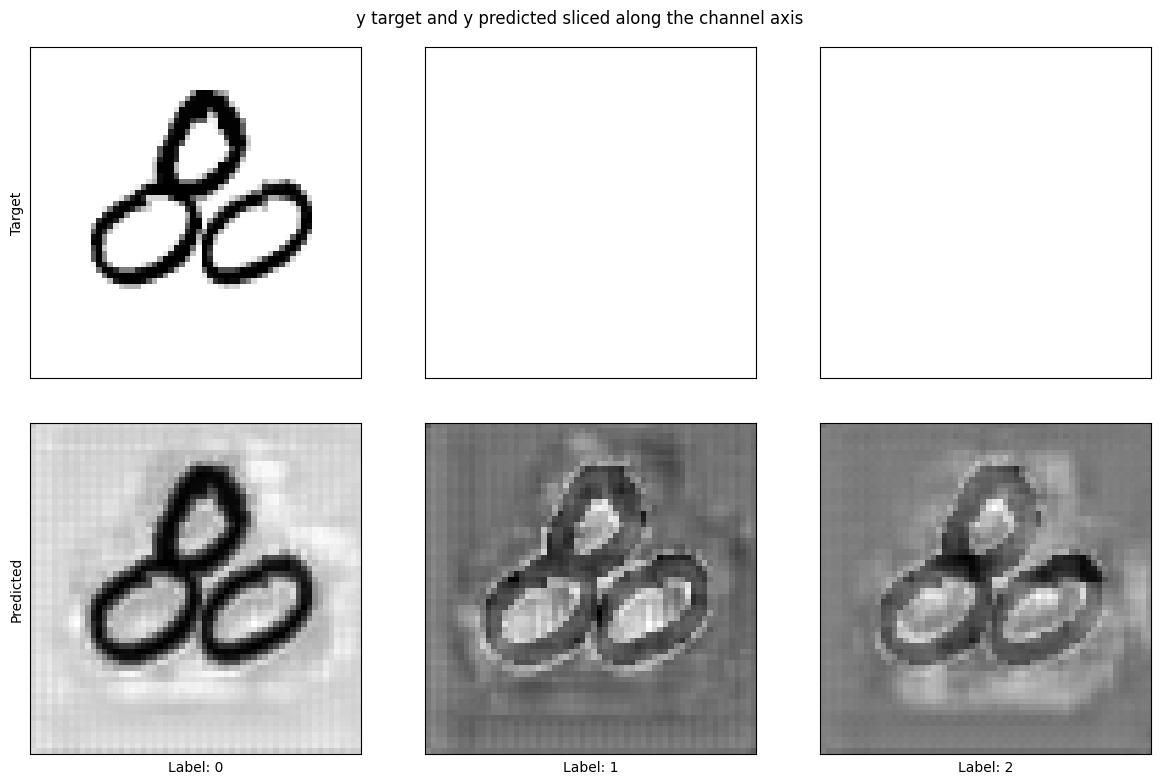

Example 5


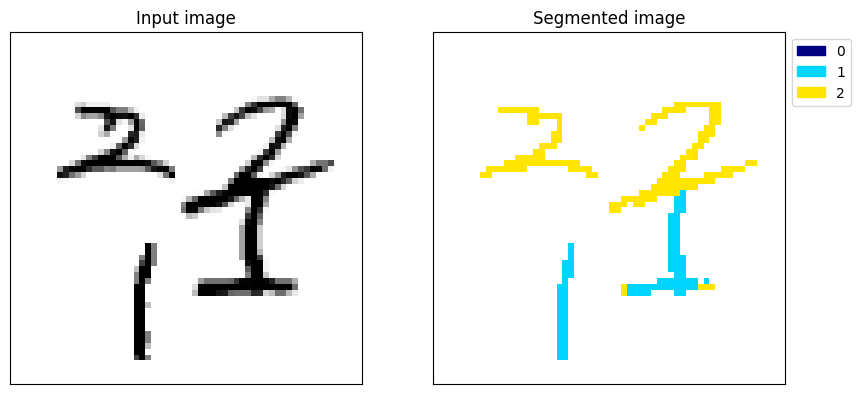

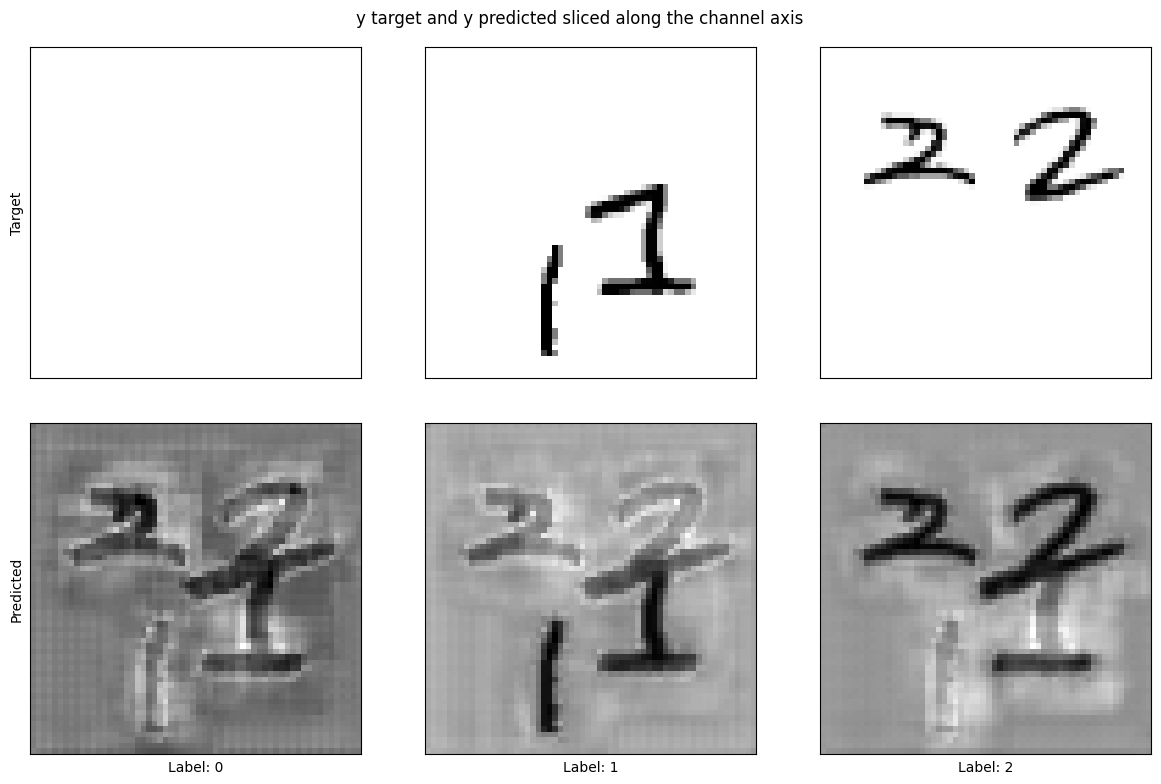

Example 6


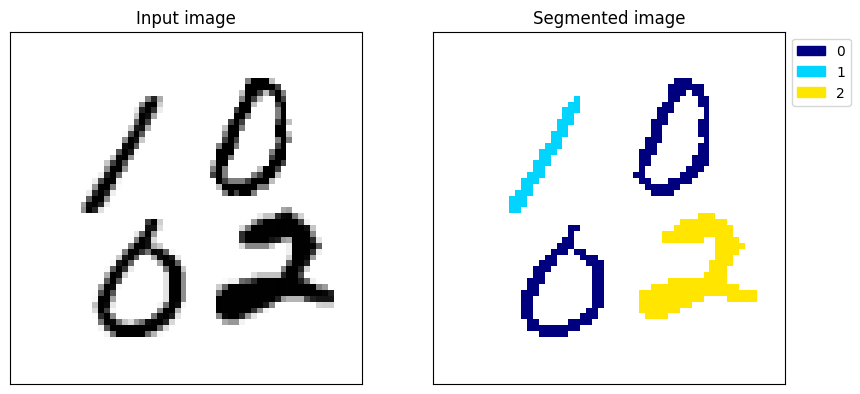

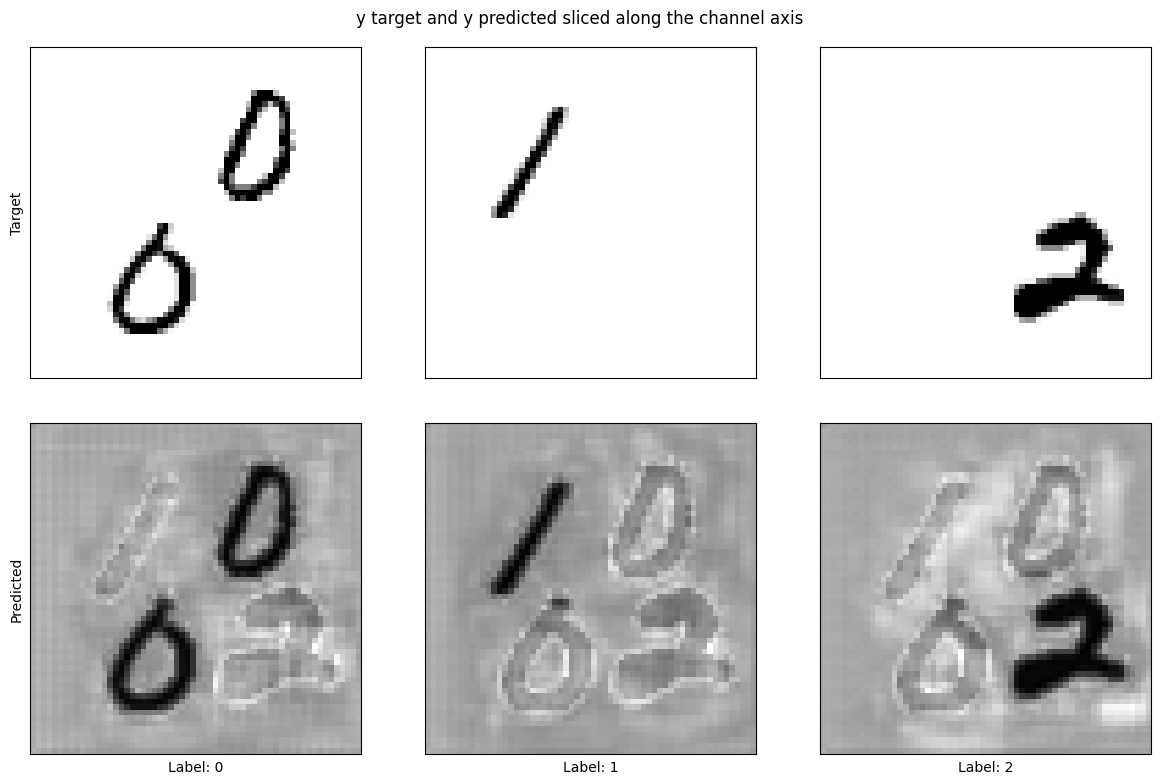

In [ ]:
from simple_deep_learning.mnist_extended.semantic_segmentation import display_segmented_image
from matplotlib import pyplot as plt

# np.random.seed(6)

checkpoint = torch.load('%s/basis_model_best.pth' % (config.outf))
model.load_state_dict(checkpoint, strict=True)

loader_iter = iter(test_loader)
for _ in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    image, mask = next(loader_iter)
    i = np.random.randint(len(image))
    with torch.no_grad():
        test_y_predicted = model(image.to(device)).detach().cpu().numpy()
    print(f'Example {i}')
    display_grayscale_array(image[i].squeeze(0).detach().cpu().numpy(), ax=ax1, title='Input image')
    display_segmented_image(test_y_predicted[i].transpose(1,2,0), ax=ax2, title='Segmented image')
    plot_class_masks(mask[i].detach().cpu().numpy().transpose(1,2,0), test_y_predicted[i].transpose(1,2,0), title='y target and y predicted sliced along the channel axis')